In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
test=pd.read_csv('yelp242a_test.csv')
train=pd.read_csv('yelp242a_train.csv')

In [3]:
test.columns

Index(['stars', 'review_count', 'GoodForKids', 'Alcohol',
       'BusinessAcceptsCreditCards', 'WiFi', 'BikeParking',
       'ByAppointmentOnly', 'WheelechairAccessible', 'OutdoorSeating',
       'RestaurantsReservations', 'DogsAllowed', 'Caters'],
      dtype='object')

# I. LR Model for b-i

In [4]:
import statsmodels.formula.api as smf

# Assuming 'train' DataFrame is already loaded with the specified columns
# Convert categorical variables to 'category' dtype if not already done
categorical_columns = ['GoodForKids', 'Alcohol', 'BusinessAcceptsCreditCards', 
                       'WiFi', 'BikeParking', 'ByAppointmentOnly', 
                       'WheelechairAccessible', 'OutdoorSeating', 
                       'RestaurantsReservations', 'DogsAllowed', 'Caters']

for col in categorical_columns:
    train[col] = train[col].astype('category')

# Build the linear regression model using statsmodels
# We use the Treatment(reference='(Missing)') to set '(Missing)' as the reference category
formula = "stars ~ review_count + " + " + ".join([f"C({col}, Treatment(reference='(Missing)'))" for col in categorical_columns])

# Fit the model
model = smf.ols(formula=formula, data=train).fit()

# Output the summary of the linear regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     48.56
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          1.30e-218
Time:                        16:42:12   Log-Likelihood:                -7295.9
No. Observations:                6272   AIC:                         1.464e+04
Df Residuals:                    6246   BIC:                         1.482e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

# II. CART for b-ii

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ], remainder='passthrough' # Include non-categorical features without transformation
)

ptrainx=preprocessor.fit_transform(train.drop(columns=['stars']))
ptestx=preprocessor.transform(test.drop(columns=['stars']))

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

initial_tree = DecisionTreeRegressor(random_state=42)
initial_tree.fit(ptrainx, train['stars'])
ccp_alphas = initial_tree.cost_complexity_pruning_path(
    ptrainx, train['stars']
)['ccp_alphas']
ccp_alphas = np.unique(np.round(ccp_alphas, 5)) #for efficiency and avoid negs from floating point errors

param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(ptrainx, train['stars'])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'ccp_alpha': array([0.000e+00, 1.000e-05, 2.000e-05, 3.000e-05, 4.000e-05, 5.000e-05,
       6.000e-05, 7.000e-05, 8.000e-05, 9.000e-05, 1.000e-04, 1.100e-04,
       1.200e-04, 1.300e-04, 1.400e-04, 1.500e-04, 1.600e-04, 1.700e-04,
       1.800e-04, 1.900e-04, 2.000e-04, 2.100e-04, 2.200e-04, 2.300e-04,
       2.400e-04, 2....
       7.900e-04, 8.000e-04, 8.200e-04, 8.400e-04, 8.700e-04, 9.000e-04,
       9.400e-04, 9.800e-04, 1.010e-03, 1.060e-03, 1.110e-03, 1.120e-03,
       1.230e-03, 1.330e-03, 1.520e-03, 1.550e-03, 1.650e-03, 1.690e-03,
       1.810e-03, 1.820e-03, 1.910e-03, 2.010e-03, 2.270e-03, 2.390e-03,
       2.690e-03, 2.890e-03, 3.240e-03, 4.000e-03, 1.061e-02, 1.131e-02,
       1.766e-02, 6.471e-02])},
             scoring='neg_mean_squared_error')

# OSR for b-iii

In [7]:
def OSR2(y_test, y_pred, y_train):
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return 1 - SSE/SST

print(OSR2(test['stars'], grid_search.best_estimator_.predict(ptestx), train['stars']))

0.17955599933916455


In [11]:
print(OSR2(test['stars'], model.predict(test.drop(columns=['stars'])), train['stars']))

0.17593242496774308


# Classification

In [12]:
train['fourOrAbove'] = (train['stars'] >= 4).astype(int)
test['fourOrAbove'] = (test['stars'] >= 4).astype(int)

In [17]:
lr_predictions = model.predict(test.drop(columns=['stars', 'fourOrAbove']))
cart_predictions = grid_search.best_estimator_.predict(ptestx)

lr_classification = (lr_predictions >= 4).astype(int)
cart_classification = (cart_predictions >= 4).astype(int)

# Display the first few results for both models
print("First five Linear Regression Predictions:")
print(lr_classification[:5])
print("\n First five CART Predictions:")
print(cart_classification[:5])

First five Linear Regression Predictions:
0    0
1    0
2    0
3    0
4    1
dtype: int64

 First five CART Predictions:
[0 0 0 0 1]


# Logistic Regression Classification

In [27]:
import statsmodels.formula.api as smf

for col in categorical_columns:
    train[col] = train[col].astype('category')

formula = "fourOrAbove ~ review_count + " + " + ".join([f"C({col}, Treatment(reference='(Missing)'))" for col in categorical_columns])

logistic_model = smf.logit(formula=formula, data=train).fit()

print(logistic_model.summary())


Optimization terminated successfully.
         Current function value: 0.612512
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            fourOrAbove   No. Observations:                 6272
Model:                          Logit   Df Residuals:                     6246
Method:                           MLE   Df Model:                           25
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:                  0.1081
Time:                        17:10:42   Log-Likelihood:                -3841.7
converged:                       True   LL-Null:                       -4307.1
Covariance Type:            nonrobust   LLR p-value:                2.537e-180
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

# CART Classification

In [28]:
initial_tree = DecisionTreeRegressor(random_state=42)
initial_tree.fit(ptrainx, train['fourOrAbove'])
ccp_alphas = initial_tree.cost_complexity_pruning_path(
    ptrainx, train['fourOrAbove']
)['ccp_alphas']
ccp_alphas = np.unique(np.round(ccp_alphas, 5)) #for efficiency and avoid negs from floating point errors

param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(ptrainx, train['fourOrAbove'])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'ccp_alpha': array([0.00e+00, 1.00e-05, 2.00e-05, 3.00e-05, 4.00e-05, 5.00e-05,
       6.00e-05, 7.00e-05, 8.00e-05, 9.00e-05, 1.00e-04, 1.10e-04,
       1.20e-04, 1.30e-04, 1.40e-04, 1.50e-04, 1.60e-04, 1.70e-04,
       1.80e-04, 1.90e-04, 2.00e-04, 2.10e-04, 2.20e-04, 2.30e-04,
       2.40e-04, 2.50e-04, 2.60e-04, 2.70e-04, 2.80e-04, 2.90e-04,
       3.00e-04, 3.30e-04, 3.40e-04, 3.50e-04, 3.60e-04, 3.80e-04,
       3.90e-04, 4.50e-04, 4.60e-04, 4.70e-04, 4.90e-04, 5.30e-04,
       5.50e-04, 5.90e-04, 6.20e-04, 6.50e-04, 7.00e-04, 8.30e-04,
       8.50e-04, 9.00e-04, 1.22e-03, 1.54e-03, 2.43e-03, 3.47e-03,
       2.07e-02])},
             scoring='neg_mean_squared_error')

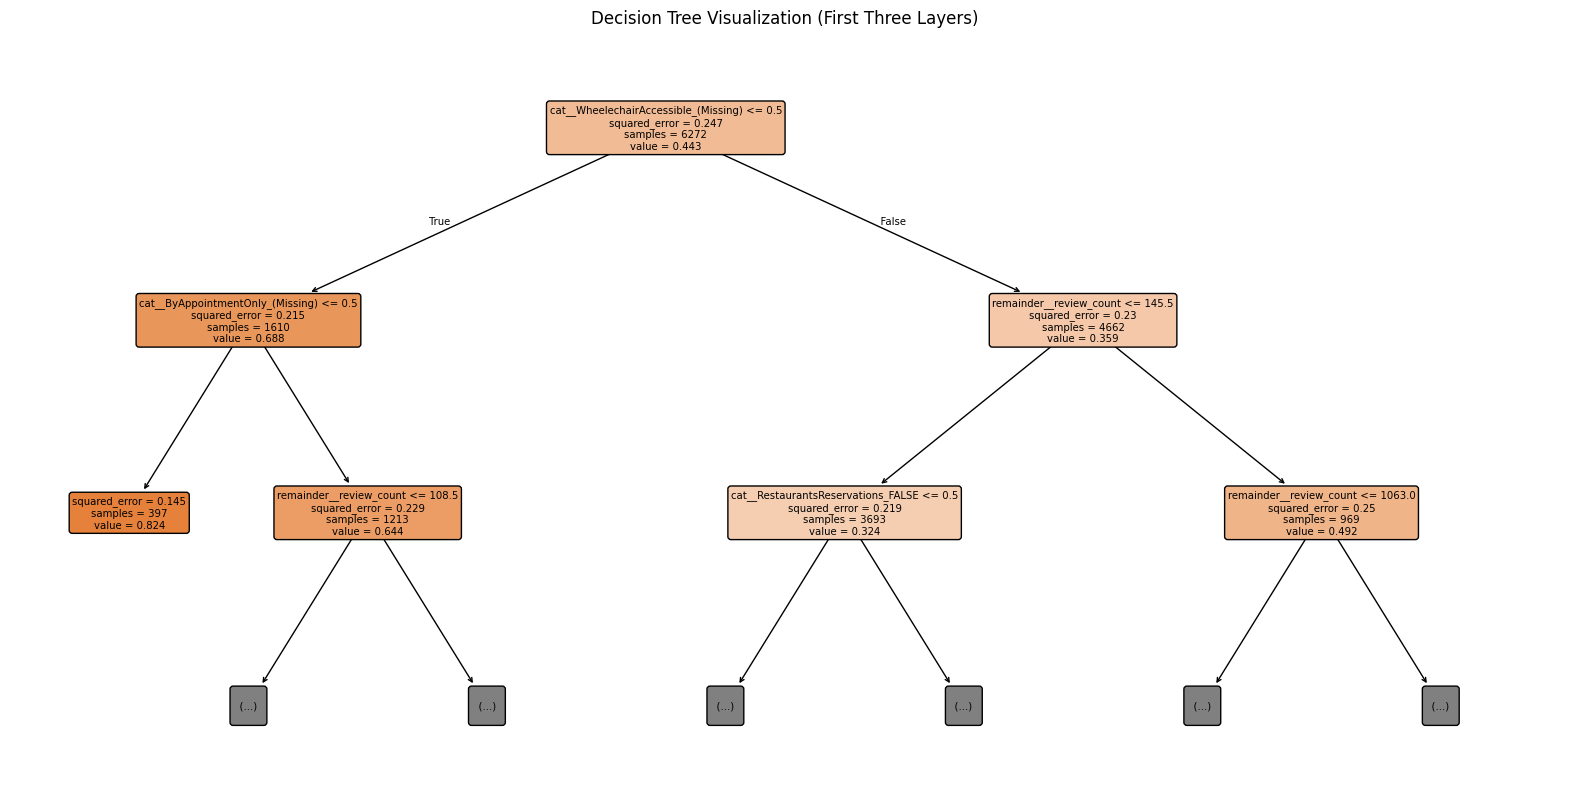

In [31]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get the best decision tree model from the grid search
best_tree = grid_search.best_estimator_

# Plot the tree diagram for the first two layers (max_depth=2)
plt.figure(figsize=(20, 10))
plot_tree(best_tree, max_depth=2, feature_names=preprocessor.get_feature_names_out(), 
          class_names=['Below 4', 'Four or Above'], filled=True, rounded=True)
plt.title("Decision Tree Visualization (First Three Layers)")
plt.show()

# Classification Results

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Baseline model: predict the most frequent outcome
most_frequent_outcome = train['fourOrAbove'].mode()[0]
baseline_predictions = [most_frequent_outcome] * len(test)

# Function to calculate TPR and FPR
def calculate_tpr_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

models = {
    'Baseline': baseline_predictions,
    'Linear Regression': lr_classification,
    'CART Regression': cart_classification,
    'Logistic Regression': (logistic_model.predict(test.drop(columns=['stars', 'fourOrAbove'])) >= 0.5).astype(int),
    'CART Classification': (best_tree.predict(ptestx) >= 0.5).astype(int)
}

performance_metrics = []

for model_name, predictions in models.items():
    accuracy = accuracy_score(test['fourOrAbove'], predictions)
    tpr, fpr = calculate_tpr_fpr(test['fourOrAbove'], predictions)
    performance_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'TPR': tpr,
        'FPR': fpr
    })

performance_df = pd.DataFrame(performance_metrics)
print(performance_df)

                 Model  Accuracy       TPR       FPR
0             Baseline  0.563616  0.000000  0.000000
1    Linear Regression  0.634673  0.212276  0.038284
2      CART Regression  0.648438  0.259165  0.050165
3  Logistic Regression  0.679315  0.487639  0.172277
4  CART Classification  0.661086  0.551577  0.254125
